## 0. Goal
Train the VAE on chopped spectrogram dataset. Use the dataset where number of windows is proportional to the syllable duration. <br>
Apply the latest VAE training codes to other birds, use only one window width (32ms)

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle, gc
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze, empty means all syllable with annotation
syl = ['v', 'b', 'h', 'e', 'x']
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram2'
spec_run = 'spec_goffinet_traj_256_236'
# where to save chopped spec 
chop_suffix = 'Chop5'
# where to save VAE results
vae_suffix = 'VAE5'

In [5]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 236, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': 1.5, # minimum log-spectrogram value
    'spec_max_val': 7, # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'pad': 0.08,  # when extracting syllables for calculating spectrograms, pad before syllable onset and after syllable onset, unit is sec
    'win_frame': 32,  # duration of the sliding window, unit is spectrogram column
    'hop_frame': 1, # how much to slide for consecutive window, unit is spectrogram column
    'win_pad': 32, # how much to include before syllable onset, unit is spectrogram column, default to one sliding window
}

In [6]:
# # vary sliding window duration
# win_list =  [16,   24,  32,  40,  48,  64, 80]
# ratio_list = [0.25, 0.5, 0.5, 0.5, 0.5, 1,  1]  # adjust the number of syllables to sample, set a ratio relative to the total number of syllables

In [7]:
# vary sliding window duration
win_list =  [32]
ratio_list = [0.5]  # adjust the number of syllables to sample, set a ratio relative to the total number of syllables

## 2. Chop spectrograms into windows, then run VAE

Processing for pair2RigBCU25...
Spectrogram window size (ms): 12.800
Spectrogram window hop (ms): 1.000
Sliding window 32 spec columns, slide by 1 columns, pad by 32 columns
Sliding window 32.0 ms, slide by 1.0 ms, pad by 32.0 ms
traj_chop_32_1_32
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/Chop5/pair2RigBCU25.traj_chop_32_1_32.chop.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/Chop5/pair2RigBCU25.traj_chop_32_1_32.chop.info.csv
(58790, 12)
Counter({'x': 21523, 'v': 16452, 'h': 13331, 'b': 5253, 'e': 2231})
v: total 16452 syllables 	 sampled 8226 syllables
b: total 5253 syllables 	 sampled 2626 syllables
h: total 13331 syllables 	 sampled 6665 syllables
e: total 2231 syllables 	 sampled 1115 syllables
x: total 21523 syllables 	 sampled 10761 syllables
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/Chop5/pair2RigBCU25.traj_chop_32_1_32.idx_rd.pkl
Sampling spectrogram windows from v...
Sampling spectrogram windows from b...
Sampling spectrogr

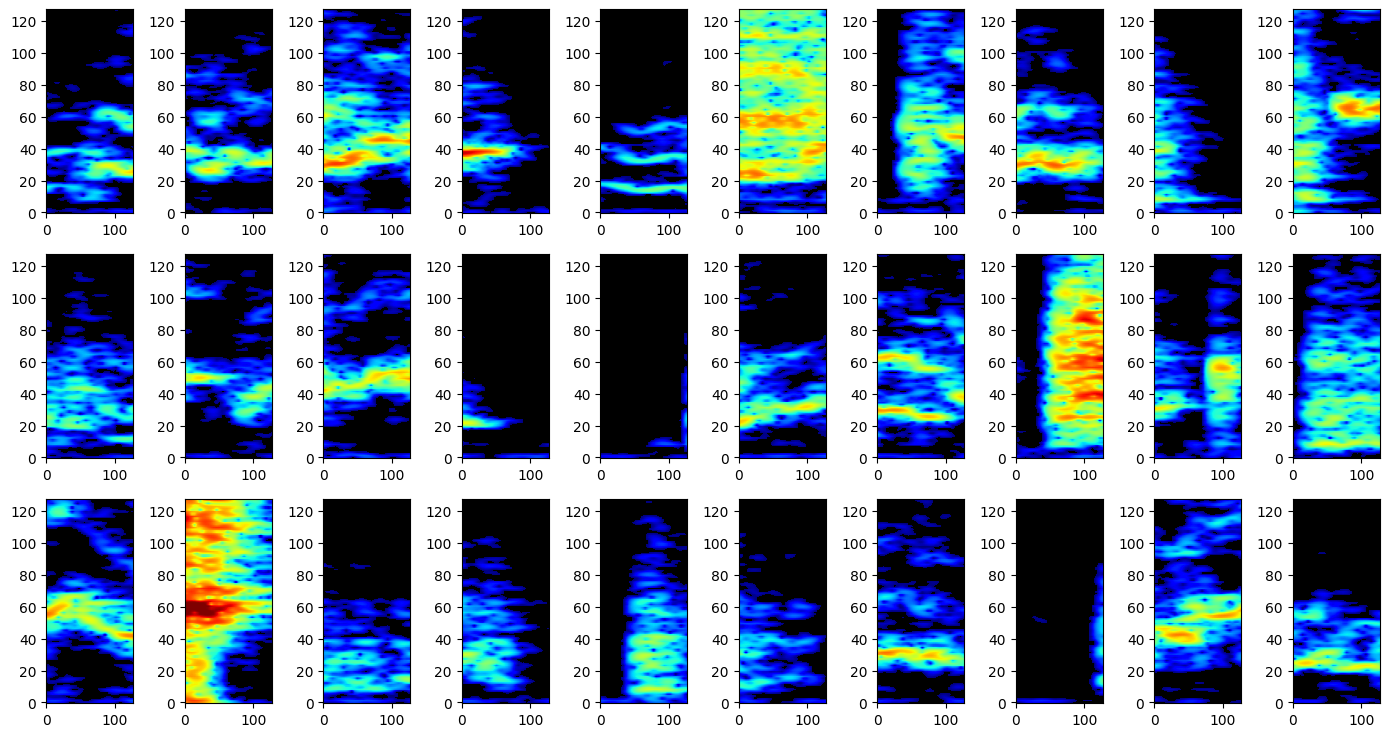

(161252, 128, 128)
Processing for pair2RigBCU25 traj_chop_32_1_32...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Traj/VAE5/traj_chop_32_1_32
(161252, 16)
Training: epochs 0 to 50
Training set: 161252
Test set: 161252


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 1352.4226
Epoch: 1 Average loss: 439.2112
Epoch: 2 Average loss: 383.6562
Epoch: 3 Average loss: 352.9687
Epoch: 4 Average loss: 334.7536
Epoch: 5 Average loss: 321.9217
Epoch: 6 Average loss: 315.2271
Epoch: 7 Average loss: 309.2843
Epoch: 8 Average loss: 303.9578
Epoch: 9 Average loss: 295.7675
Epoch: 10 Average loss: 287.4545
Epoch: 11 Average loss: 282.4570
Epoch: 12 Average loss: 277.9313
Epoch: 13 Average loss: 274.5703
Epoch: 14 Average loss: 272.5451
Epoch: 15 Average loss: 269.1124
Epoch: 16 Average loss: 267.0527
Epoch: 17 Average loss: 264.7599
Epoch: 18 Average loss: 263.3555
Epoch: 19 Average loss: 260.5681
Epoch: 20 Average loss: 259.5311
Epoch: 21 Average loss: 256.9259
Epoch: 22 Average loss: 255.1779
Epoch: 23 Average loss: 253.9215
Epoch: 24 Average loss: 252.2706
Epoch: 25 Average loss: 251.0955
Epoch: 26 Average loss: 249.7646
Epoch: 27 Average loss: 248.1326
Epoch: 28 Average loss: 246.6647
Epoch: 29 Average loss: 245.5600
Epoch: 30 Average l

2520it [03:01, 13.86it/s]


(161252, 32)


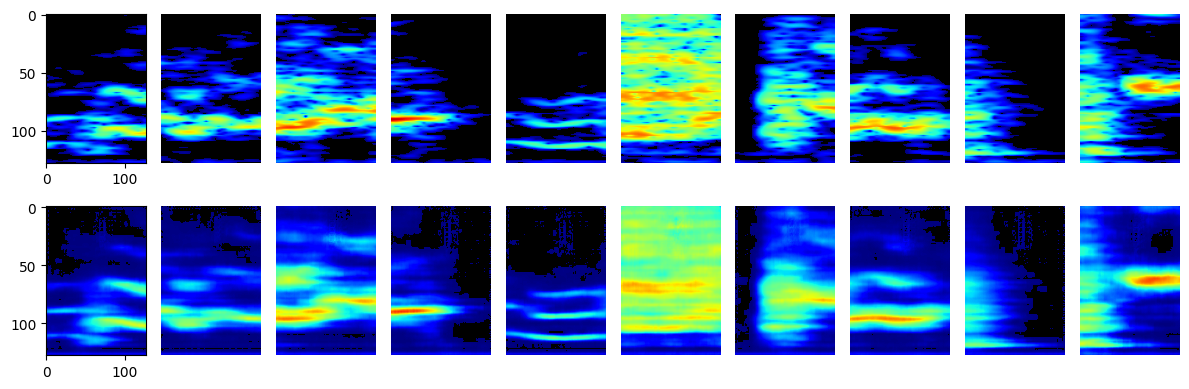

In [8]:
for wi in range(0, len(win_list)):
# for wi in range(1):
    win_frame = win_list[wi]
    # replace parameters 
    p['win_frame'] = win_frame
    p['win_pad'] = win_frame

    # how many syllables to sample per category
    syl_ratio = ratio_list[wi]

    bi = 3
    # # for bi in range(len(birdIDs)):
    # for bi in range(1):
    bd = birdIDs[bi]
    print(f'Processing for {bd}...')
    # change the color limit
    p['spec_min_val'] = clims[bi][0]
    p['spec_max_val'] = clims[bi][1]
    win_ms = p['nperseg']/p['fs']*1000
    hop_ms = (p['nperseg']-p['noverlap'])/p['fs']*1000
    print(f'Spectrogram window size (ms): {win_ms:.3f}')
    print(f'Spectrogram window hop (ms): {hop_ms:.3f}')
    # calculate sliding window duration
    slide_win_ms = p['win_frame'] * hop_ms
    slide_hop_ms = p['hop_frame'] * hop_ms
    slide_pad_ms = p['win_pad'] * hop_ms
    print(f'Sliding window {p["win_frame"]} spec columns, slide by {p["hop_frame"]} columns, pad by {p["win_pad"]} columns')
    print(f'Sliding window {slide_win_ms} ms, slide by {slide_hop_ms} ms, pad by {slide_pad_ms} ms')
    ## given the current run a name
    run_name = f'traj_chop_{p["win_frame"]}_{p["hop_frame"]}_{p["win_pad"]}'
    print(run_name)

    # save to specific folder
    fd_save = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav', bd, 'Traj', chop_suffix)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    fn_h5 = os.path.join(fd_save, f'{bd}.{run_name}.chop.h5')
    fn_info = os.path.join(fd_save, f'{bd}.{run_name}.chop.info.csv')
    print(fn_h5)
    print(fn_info)

    # load the calculated spectrogram dataset
    fd_spec = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav', bd, 'Traj', spec_suffix)
    fn_spec = os.path.join(fd_spec, f'{bd}.{spec_run}.h5')
    fn_spec_info = os.path.join(fd_spec, f'{bd}.{spec_run}.info.csv')
    info_spec = pd.read_csv(fn_spec_info, delimiter=',', index_col=0)
    print(info_spec.shape)
    info_spec.head()

    # sample syllables for each category recording to the desired ratio, record the row index
    print(Counter(info_spec['label']))
    idx_rd = []
    random.seed(1992)
    for s in syl:
        idx_syl = list(info_spec[info_spec['label']==s].index)
        # sample 
        # sample_num = min([num_syl, len(idx_syl)])
        sample_num = int(syl_ratio * len(idx_syl))
        i_r = random.sample(idx_syl, sample_num)
        print(f'{s}: total {len(idx_syl)} syllables \t sampled {len(i_r)} syllables')
        idx_rd.append(i_r)
    # save the sampled index to disk for future use
    fn_idx = os.path.join(fd_save, f'{bd}.{run_name}.idx_rd.pkl')
    with open(fn_idx, 'wb') as f:
        pickle.dump(idx_rd, f)
    print(fn_idx)

    # sample spectrogram windows from each sampled syllable
    res_all = []
    # loop through syllable categories
    # si = 3
    for si in range(len(syl)):
        i_r = idx_rd[si]
        ## Sample spectrogram windows
        print(f'Sampling spectrogram windows from {syl[si]}...')
        with Parallel(n_jobs=48, verbose=0) as parallel:
            res = parallel(delayed(vae_goffinet.ZZ_sampleSpecWin_v2)(fn_spec, ri, p, win_prop=1, resize=True) for ri in i_r)
        res_all += res

    # flatten the result
    temp = [aa[0] for aa in res_all]
    specs = [arr for sublist in temp if sublist for arr in sublist]
    df_list = [aa[1] for aa in res_all]
    info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
    print(len(specs), info.shape)

    # plot some example spectrograms
    nrow = 3
    ncol = 10
    random.seed(1118)
    plot_rd = random.sample(range(len(specs)), nrow*ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(14, nrow*2.5))
    xmax = max([specs[ii].shape[1] for ii in plot_rd])
    for ii in range(len(plot_rd)):
        plot_i = ii//ncol
        plot_j = ii%ncol
        ax = axes[plot_i][plot_j]
        ax.imshow(specs[plot_rd[ii]], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
    plt.tight_layout()
    plt.show()
    # save figure
    fn_fig = os.path.join(fd_save, f'{bd}.{run_name}.pdf')
    fig.savefig(fn_fig)

    # save padded spectrograms as h5 file 
    spec_win_all = np.stack(specs, axis=0)
    print(spec_win_all.shape)
    with h5py.File(fn_h5, 'w') as f:
        f.create_dataset('spec_win_all', data=spec_win_all)

    # also save the meta info
    mapped_spec = info_spec.iloc[info['ri'].values].reset_index(drop=True)
    # Combine both dataframes
    info_combined = pd.concat([info.reset_index(drop=True), mapped_spec], axis=1)
    info_combined.to_csv(fn_info)
    
    # release RAM
    del info_spec, res, res_all, info, temp, specs, df_list, spec_win_all, mapped_spec, info_combined
    gc.collect()
    
    ## Run VAE
    rn = run_name
    chop_run = run_name
    fd_save = os.path.join(fd_data, bd, 'Traj', vae_suffix, rn)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)

    print(f'Processing for {bd} {rn}...')
    print(f'Save results to {fd_save}')
    ## load spectrograms and meta info
    fn_spec = os.path.join(fd_data, bd, 'Traj', chop_suffix, f'{bd}.{chop_run}.chop.h5')
    fn_info = os.path.join(fd_data, bd, 'Traj', chop_suffix, f'{bd}.{chop_run}.chop.info.csv')

    info = pd.read_csv(fn_info, index_col=0)

    print(info.shape)


    ## train VAE network
    # create dataloader from h5 file
    train_data = vae_goffinet.SpecDataset(fn_spec)
    # set a random seed
    g = torch.Generator()
    g.manual_seed(42)
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
    loaders = {'train':train_dataloader, 'test':train_dataloader}

    # init VAE model then train
    model = vae_goffinet.VAE(save_dir=fd_save)
    model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

    # save model
    fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
    model.save_state(fn_model)

    ## Obtain latent representation
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

    # loop through dataloader, obtain model latent space
    latent_m = np.zeros((info.shape[0], 32))
    latent_d = np.zeros((info.shape[0], 32))
    recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
    model.eval()
    count = 0
    for i, data in tqdm.tqdm(enumerate(train_dataloader)):
        data = data.to('cuda:0')
        with torch.no_grad():
            _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
            a = rec.shape[0]
            latent_m[count:(count+a),:] = mu
            latent_d[count:(count+a),:] = d
            recon[count:(count+a),:,:] = rec
            count += a

    # save the latent representations
    fn_latentM = os.path.join(fd_save, 'latentM.csv')
    np.savetxt(fn_latentM, latent_m, delimiter=',')
    fn_latentD = os.path.join(fd_save, 'latentD.csv')
    np.savetxt(fn_latentD, latent_d, delimiter=',')
    print(latent_m.shape)

    ## check recontruction accuracy (optional)
    # plot some random samples
    fig, ax = plt.subplots(2, 10, figsize=[12,4])
    random.seed(1118)
    random_i = random.sample(list(range(recon.shape[0])), 10)
    with h5py.File(fn_spec, 'r') as file:
        for ii in range(10):
            spec = train_data[random_i[ii],:,:].numpy()
            ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            spec = recon[random_i[ii],:,:]
            ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            if ii>0:
                ax[0][ii].axis('off')
                ax[1][ii].axis('off')
    plt.tight_layout()
    # save fig
    fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
    fig.savefig(fn_fig)

    # release RAM
    del latent_m, latent_d, recon, spec, info
    gc.collect()

#### Check RAM usage

In [11]:
import pandas as pd
from pympler import asizeof

var_info = []
for name, val in list(globals().items()):  # Make list copy
    try:
        size = asizeof.asizeof(val)
        var_info.append((name, size))
    except:
        continue

df = pd.DataFrame(var_info, columns=["Variable", "Size (Bytes)"])
df["Size (MB)"] = df["Size (Bytes)"] / 1024**2
df.sort_values(by="Size (Bytes)", ascending=False, inplace=True)
print(df)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/pympler/asizeof.py:651: UserWarning: Iterating '<class 'traitlets.config.loader.Config'>': TypeError("'LazyConfigValue' object is not iterable")
  warnings.warn("Iterating '%s': %r" % (_classof(obj), x))
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/pympler/asizeof.py:651: UserWarning: Iterating '<class 'traitlets.config.loader.Config'>': TypeError("'LazyConfigValue' object is not iterable")
  warnings.warn("Iterating '%s': %r" % (_classof(obj), x))


           Variable  Size (Bytes)     Size (MB)
127            spec   23324918032  22244.375259
109            info    1737379848   1656.894539
119             rec       2228536      2.125298
90          idx_syl        977296      0.932022
88           idx_rd        842880      0.803833
..              ...           ...           ...
13             open             0      0.000000
43   ListedColormap             0      0.000000
34          delayed             0      0.000000
41       DataLoader             0      0.000000
38          Counter             0      0.000000

[138 rows x 3 columns]
